# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [692]:
# Import the libraries you will be using for analysis

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path


In [693]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.3.1
pandas version: 2.3.1
matplotlib version: 3.10.3
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:

sample_fraction = 0.01
scale_factor = 1.0 / sample_fraction
# data_dir = Path("/Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records")
# shapefile_path = Path("/Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/taxi_zones/taxi_zones.shp")
data_dir = Path("./trip_records")
shapefile_path = Path("./taxi_zones/taxi_zones.shp")

# Output folder
out_dir = data_dir
out_dir.mkdir(parents=True, exist_ok=True)


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [695]:
dfs = []
for month in range(1, 13):
    file_name = data_dir / f"2023-{month}.parquet"
    print(f"Loading {file_name}")
    month_df = pd.read_parquet(file_name)
    # parse datetimes
    month_df['tpep_pickup_datetime'] = pd.to_datetime(month_df['tpep_pickup_datetime'])
    month_df['tpep_dropoff_datetime'] = pd.to_datetime(month_df['tpep_dropoff_datetime'])
    month_df['pickup_date'] = month_df['tpep_pickup_datetime'].dt.date
    month_df['pickup_hour'] = month_df['tpep_pickup_datetime'].dt.hour

    # stratified sample per date-hour
    sampled = (month_df.groupby(['pickup_date', 'pickup_hour'], group_keys=False)
                       .apply(lambda x: x.sample(frac=sample_fraction, random_state=42) 
                              if (len(x) > 0) else x))
    dfs.append(sampled)

sampled_data = pd.concat(dfs, ignore_index=True)
print("Sampled rows:", sampled_data.shape)

sample_csv = out_dir / "sample_2023.csv"
sample_parquet = out_dir / "sample_2023.parquet"
sampled_data.to_csv(sample_csv, index=False)
sampled_data.to_parquet(sample_parquet, index=False, engine="pyarrow")
print("Saved sampled files.")


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-1.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-2.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-3.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-4.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-5.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-6.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-7.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-8.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-9.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-10.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-11.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Loading /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records/2023-12.parquet


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3265934202.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_fraction, random_state=42)


Sampled rows: (379268, 22)
Saved sampled files.


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [696]:
# ---------------------------
# Load sampled file for cleaning & analysis
# ---------------------------
df = pd.read_parquet(sample_parquet)



#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [697]:
df.reset_index(drop=True, inplace=True)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [698]:
# combine duplicate airport fee columns if present
if "airport_fee" in df.columns and "Airport_fee" in df.columns:
    df["airport_fee"] = df["airport_fee"].fillna(0) + df["Airport_fee"].fillna(0)
    df.drop(columns=["Airport_fee"], inplace=True)



**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [699]:
monetary_columns = [
    "fare_amount", "extra", "mta_tax", "tip_amount",
    "tolls_amount", "improvement_surcharge",
    "total_amount", "congestion_surcharge", "airport_fee"
]

for col in monetary_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).clip(lower=0)

Did you notice something different in the `RatecodeID` column for above records?

In [700]:
# impute passenger_count, RatecodeID, congestion_surcharge
if "passenger_count" in df.columns:
    df["passenger_count"] = pd.to_numeric(df["passenger_count"], errors="coerce")
    df["passenger_count"].fillna(df["passenger_count"].median(), inplace=True)
if "RatecodeID" in df.columns:
    df["RatecodeID"] = pd.to_numeric(df["RatecodeID"], errors="coerce")
    if not df["RatecodeID"].mode().empty:
        df["RatecodeID"].fillna(df["RatecodeID"].mode()[0], inplace=True)
if "congestion_surcharge" in df.columns:
    df["congestion_surcharge"].fillna(0, inplace=True)


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3181978130.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["passenger_count"].fillna(df["passenger_count"].median(), inplace=True)
/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3181978130.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [701]:
for col in df.columns:
    if df[col].dtype.kind in "iufc":  # numeric
        df[col].fillna(0, inplace=True)
    else:
        df[col].fillna("Unknown", inplace=True)



/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2475442545.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2475442545.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [702]:
if "passenger_count" in df.columns:
    df["passenger_count"] = pd.to_numeric(df["passenger_count"], errors="coerce")
    df["passenger_count"].fillna(df["passenger_count"].median(), inplace=True)


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/644145645.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["passenger_count"].fillna(df["passenger_count"].median(), inplace=True)


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [703]:
if "RatecodeID" in df.columns:
    df["RatecodeID"] = pd.to_numeric(df["RatecodeID"], errors="coerce")
    if not df["RatecodeID"].mode().empty:
        df["RatecodeID"].fillna(df["RatecodeID"].mode()[0], inplace=True)


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/723019469.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["RatecodeID"].fillna(df["RatecodeID"].mode()[0], inplace=True)


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [704]:
if "congestion_surcharge" in df.columns:
    df["congestion_surcharge"].fillna(0, inplace=True)


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/1285850843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["congestion_surcharge"].fillna(0, inplace=True)


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [705]:
for col in df.columns:
    if df[col].dtype.kind in "iufc":  # numeric
        df[col].fillna(0, inplace=True)
    else:
        df[col].fillna("Unknown", inplace=True)


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3418242453.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3418242453.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [706]:
# Outlier handling

# remove passenger_count > 6
# Continue with outlier handling
# Do any columns need standardising?

df = df[~((df.get("trip_distance", 0) < 0.1) & (df.get("fare_amount", 0) > 300))]
df = df[~((df.get("trip_distance", 0) == 0) & (df.get("fare_amount", 0) == 0) &
          (df.get("PULocationID", -1) != df.get("DOLocationID", -1)))]
df = df[df.get("trip_distance", 0) <= 250]
df = df[df.get("passenger_count", 0) <= 6]


In [707]:
# Keep valid payment types 1-4
if "payment_type" in df.columns:
    df["payment_type"] = pd.to_numeric(df["payment_type"], errors="coerce").fillna(0).astype(int)
    df = df[df["payment_type"].isin([1,2,3,4])]

# ensure datetimes parsed
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# derive time columns
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek  # 0=Mon
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['is_weekend'] = df['pickup_dayofweek'].isin([5,6])

# compute trip duration in minutes and average speed (mph)
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60.0
# avoid zero/negative durations
df['trip_duration_min'] = pd.to_numeric(df['trip_duration_min'], errors='coerce')
df = df[df['trip_duration_min'] > 0]
# speed: miles per hour
df['trip_distance'] = pd.to_numeric(df['trip_distance'], errors='coerce').fillna(0)
df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60.0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Merge zone data (shapefile) and prepare mapping for zone names
gdf_zones = gpd.read_file(shapefile_path)
gdf_zones['LocationID'] = pd.to_numeric(gdf_zones['LocationID'], errors='coerce')
gdf_zones = gdf_zones[['LocationID', 'zone', 'borough', 'geometry']]

# Map zone names onto df for pickups and dropoffs (optional columns)
df['PULocationID'] = pd.to_numeric(df['PULocationID'], errors='coerce').astype('Int64')
df['DOLocationID'] = pd.to_numeric(df['DOLocationID'], errors='coerce').astype('Int64')

# create mapping dicts
locid_to_zone = gdf_zones.set_index('LocationID')['zone'].to_dict()
locid_to_borough = gdf_zones.set_index('LocationID')['borough'].to_dict()

df['PU_zone'] = df['PULocationID'].map(locid_to_zone).fillna("Unknown")
df['PU_borough'] = df['PULocationID'].map(locid_to_borough).fillna("Unknown")
df['DO_zone'] = df['DOLocationID'].map(locid_to_zone).fillna("Unknown")
df['DO_borough'] = df['DOLocationID'].map(locid_to_borough).fillna("Unknown")


In [708]:
# 1. Analyze variations by time of day and location (bottlenecks)
#    We'll compute average speed per route and per time-of-day bucket
def tod_bucket(hour):
    if 5 <= hour < 9:
        return "Morning_peak"
    if 9 <= hour < 16:
        return "Midday"
    if 16 <= hour < 20:
        return "Evening_peak"
    if 20 <= hour < 23:
        return "Evening"
    return "Night"  # 23-5

df['tod_bucket'] = df['pickup_hour'].apply(tod_bucket)

# define route id
df['route'] = df['PULocationID'].astype(str) + "_" + df['DOLocationID'].astype(str)

# avg speed per route x tod
route_speed = (df.groupby(['route', 'tod_bucket'])
                 .agg(avg_speed_mph=('speed_mph','mean'),
                      trip_count=('speed_mph','count'),
                      median_speed=('speed_mph','median'))
                 .reset_index())
# filter routes with at least some number of trips to be meaningful (e.g., >=5)
route_speed_filtered = route_speed[route_speed['trip_count'] >= 5]

# identify slowest routes per bucket (lowest avg_speed)
slowest_by_bucket = (route_speed_filtered.sort_values(['tod_bucket','avg_speed_mph'])
                     .groupby('tod_bucket').head(10))

print("\nSlowest routes by time-of-day bucket (sample):")
print(slowest_by_bucket[['tod_bucket','route','avg_speed_mph','trip_count']].head(20))

# Save to CSV
slowest_by_bucket.to_csv(out_dir / "slowest_routes_by_tod.csv", index=False)



Slowest routes by time-of-day bucket (sample):
         tod_bucket    route  avg_speed_mph  trip_count
12672       Evening  193_193       0.000000          16
7583        Evening  146_146       0.791209           7
21299       Evening  265_265       2.673607          32
5           Evening  100_100       2.909747          19
24995       Evening    70_70       3.109429           7
7164        Evening  144_144       4.321686          13
14922       Evening  230_230       4.553667          75
13324       Evening  211_211       4.680352           9
8190        Evening  151_151       4.726826          15
12166       Evening  186_186       4.763753          22
7584   Evening_peak  146_146       0.357143           8
7486   Evening_peak  145_145       1.565078          45
11172  Evening_peak  168_168       2.670134           6
20149  Evening_peak  261_261       3.138224          10
13325  Evening_peak  211_211       3.257073          14
11972  Evening_peak  186_100       3.473017          52


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [709]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pickup_date',
 'pickup_hour',
 'pickup_dayofweek',
 'pickup_month',
 'is_weekend',
 'trip_duration_min',
 'speed_mph',
 'PU_zone',
 'PU_borough',
 'DO_zone',
 'DO_borough',
 'tod_bucket',
 'route']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

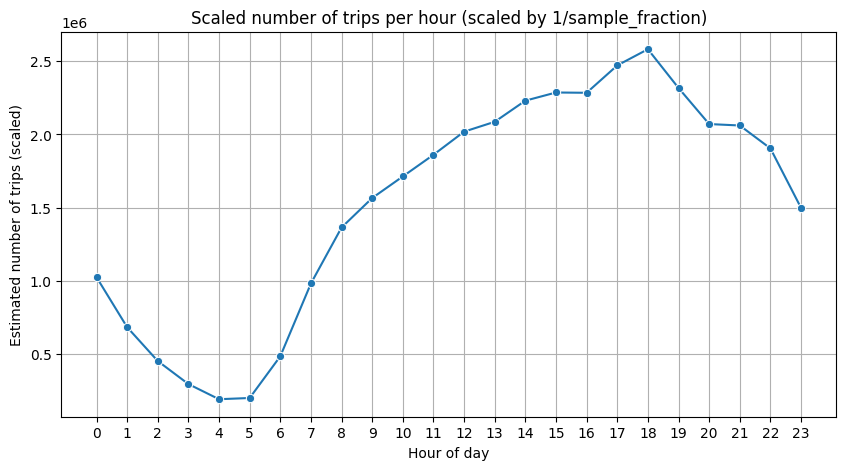


Busiest hour (sample): 18 (scaled est. trips: 2583000)


In [710]:
# Find and show the hourly trends in taxi pickups
# Find and show the daily trends in taxi pickups (days of the week)
# Show the monthly trends in pickups

# Number of trips per hour and busiest hour
trips_per_hour = df.groupby('pickup_hour').size().reset_index(name='trip_count')
trips_per_hour['scaled_trip_count'] = (trips_per_hour['trip_count'] * scale_factor).round().astype(int)

plt.figure(figsize=(10,5))
sns.lineplot(data=trips_per_hour, x='pickup_hour', y='scaled_trip_count', marker='o')
plt.title("Scaled number of trips per hour (scaled by 1/sample_fraction)")
plt.xlabel("Hour of day")
plt.ylabel("Estimated number of trips (scaled)")
plt.xticks(range(0,24))
plt.grid(True)
plt.savefig(out_dir / "trips_per_hour_scaled.png")
plt.show()
plt.close()

busiest_hour_row = trips_per_hour.loc[trips_per_hour['trip_count'].idxmax()]
busiest_hour = int(busiest_hour_row['pickup_hour'])
busiest_hour_scaled = int(busiest_hour_row['scaled_trip_count'])
print(f"\nBusiest hour (sample): {busiest_hour} (scaled est. trips: {busiest_hour_scaled})")


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [711]:
# Analyse the above parameters



Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [712]:
# Create a df with non zero entries for the selected parameters.

df_nonzero = df[(df['fare_amount'] > 0) &
                (df['trip_distance'] > 0) &
                (df['trip_duration_min'] > 0) &
                (df['passenger_count'] > 0)]
print("\nNon-zero entry dataframe shape:", df_nonzero.shape)



Non-zero entry dataframe shape: (356030, 32)


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend


Monthly revenue (scaled):
    pickup_month  total_amount  scaled_revenue
0              1     811920.20      81192020.0
1              2     768548.71      76854871.0
2              3     921519.96      92151996.0
3              4     905896.99      90589699.0
4              5     989335.80      98933580.0
5              6     925991.78      92599178.0
6              7     803340.69      80334069.0
7              8     785048.41      78504841.0
8              9     952089.09      95208909.0
9             10     996243.74      99624374.0
10            11     913943.31      91394331.0
11            12     914173.02      91417302.0


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2284154482.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_revenue, x='pickup_month', y='scaled_revenue', palette='Blues')


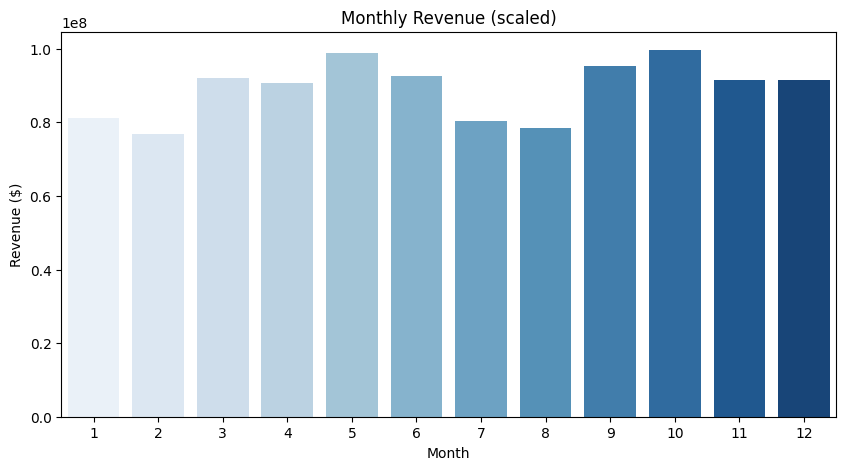

In [713]:
# Group data by month and analyse monthly revenue

monthly_revenue = df.groupby('pickup_month')['total_amount'].sum().reset_index()
monthly_revenue['scaled_revenue'] = monthly_revenue['total_amount'] * scale_factor
print("\nMonthly revenue (scaled):")
print(monthly_revenue)

plt.figure(figsize=(10,5))
sns.barplot(data=monthly_revenue, x='pickup_month', y='scaled_revenue', palette='Blues')
plt.title("Monthly Revenue (scaled)")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.savefig(out_dir / "monthly_revenue.png")
plt.show()
plt.close()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [714]:
# Calculate proportion of each quarter

df['quarter'] = df['tpep_pickup_datetime'].dt.to_period("Q")
quarterly_rev = df.groupby('quarter')['total_amount'].sum().reset_index()
quarterly_rev['scaled_revenue'] = quarterly_rev['total_amount'] * scale_factor
quarterly_rev['proportion'] = quarterly_rev['scaled_revenue'] / quarterly_rev['scaled_revenue'].sum()
print("\nQuarterly revenue proportions:")
print(quarterly_rev)



Quarterly revenue proportions:
  quarter  total_amount  scaled_revenue  proportion
0  2023Q1    2501988.87     250198887.0    0.234092
1  2023Q2    2821224.57     282122457.0    0.263961
2  2023Q3    2540478.19     254047819.0    0.237693
3  2023Q4    2824360.07     282436007.0    0.264254


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

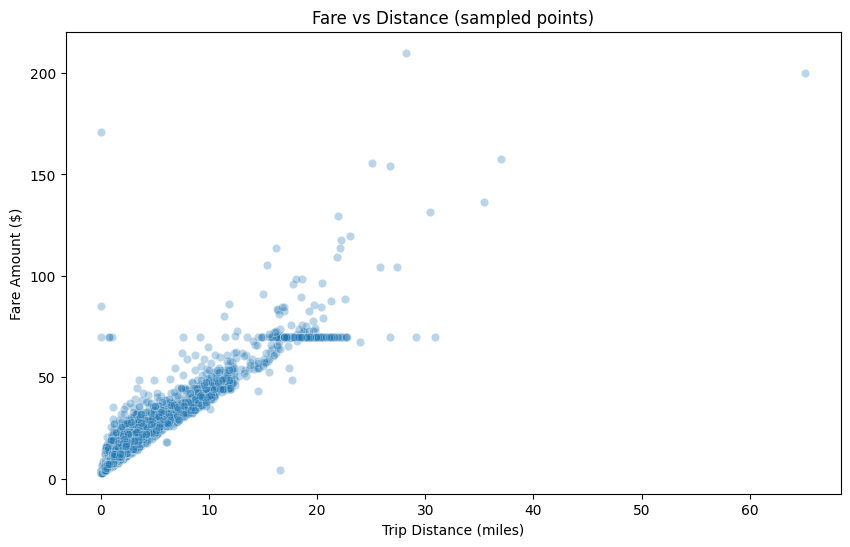

In [715]:
# Show how trip fare is affected by distance
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nonzero.sample(n=min(5000,len(df_nonzero)), random_state=42),
                x='trip_distance', y='fare_amount', alpha=0.3)
plt.title("Fare vs Distance (sampled points)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.savefig(out_dir / "fare_vs_distance.png")
plt.show()
plt.close()



**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

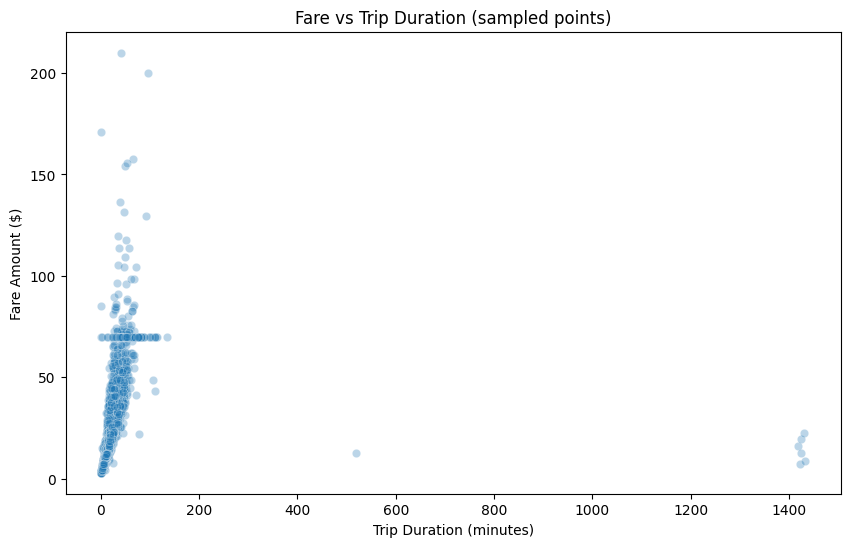

In [716]:
# Show relationship between fare and trip duration

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nonzero.sample(n=min(5000,len(df_nonzero)), random_state=42),
                x='trip_duration_min', y='fare_amount', alpha=0.3)
plt.title("Fare vs Trip Duration (sampled points)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Fare Amount ($)")
plt.savefig(out_dir / "fare_vs_duration.png")
plt.show()
plt.close()


Average fare by passenger count:
   passenger_count  fare_amount
0              0.0    16.942941
1              1.0    19.566473
2              2.0    22.235475
3              3.0    21.943826
4              4.0    23.311243
5              5.0    18.851012
6              6.0    19.037642


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/68419886.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fare_by_pax, x='passenger_count', y='fare_amount', palette='viridis')


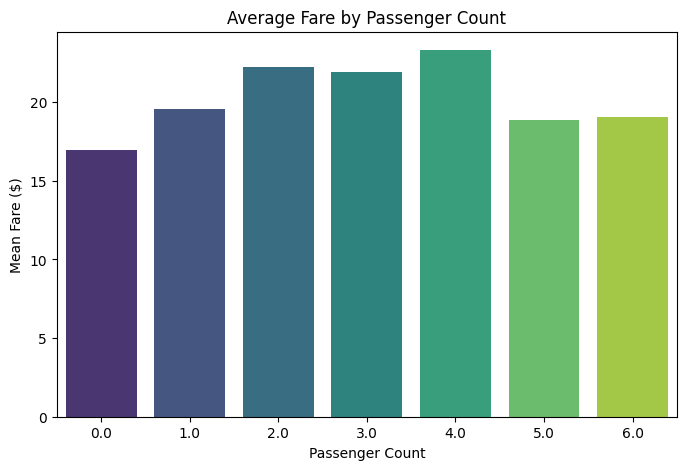

In [717]:
# Show relationship between fare and number of passengers

fare_by_pax = df.groupby('passenger_count')['fare_amount'].mean().reset_index()
print("\nAverage fare by passenger count:")
print(fare_by_pax)

plt.figure(figsize=(8,5))
sns.barplot(data=fare_by_pax, x='passenger_count', y='fare_amount', palette='viridis')
plt.title("Average Fare by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Mean Fare ($)")
plt.savefig(out_dir / "fare_vs_passenger_count.png")
plt.show()
plt.close()


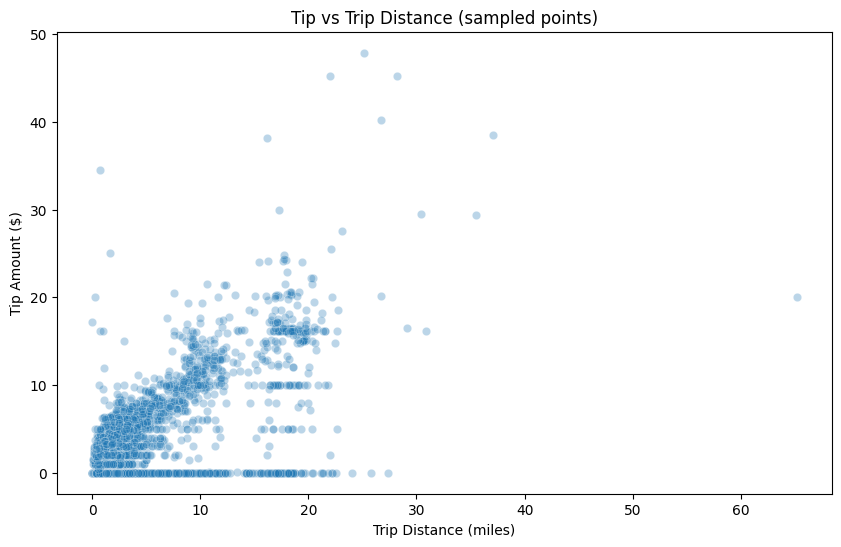

In [718]:
# Show relationship between tip and trip distance

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nonzero.sample(n=min(5000,len(df_nonzero)), random_state=42),
                x='trip_distance', y='tip_amount', alpha=0.3)
plt.title("Tip vs Trip Distance (sampled points)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.savefig(out_dir / "tip_vs_distance.png")
plt.show()
plt.close()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)


Payment type distribution:
   payment_type   count
0             1  298588
1             2   63097
2             4    2733
3             3    1744


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/451516918.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_counts, x='payment_type', y='count', palette='Set2')


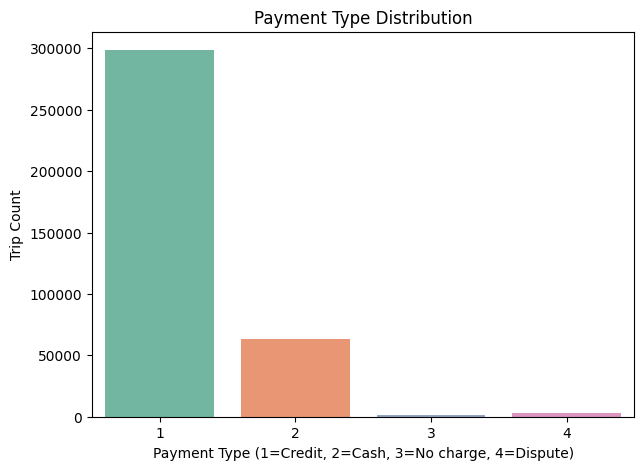

In [719]:
# Analyse the distribution of different payment types (payment_type).

payment_counts = df['payment_type'].value_counts().reset_index()
payment_counts.columns = ['payment_type','count']
print("\nPayment type distribution:")
print(payment_counts)

plt.figure(figsize=(7,5))
sns.barplot(data=payment_counts, x='payment_type', y='count', palette='Set2')
plt.title("Payment Type Distribution")
plt.xlabel("Payment Type (1=Credit, 2=Cash, 3=No charge, 4=Dispute)")
plt.ylabel("Trip Count")
plt.savefig(out_dir / "payment_type_distribution.png")
plt.show()
plt.close()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [720]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

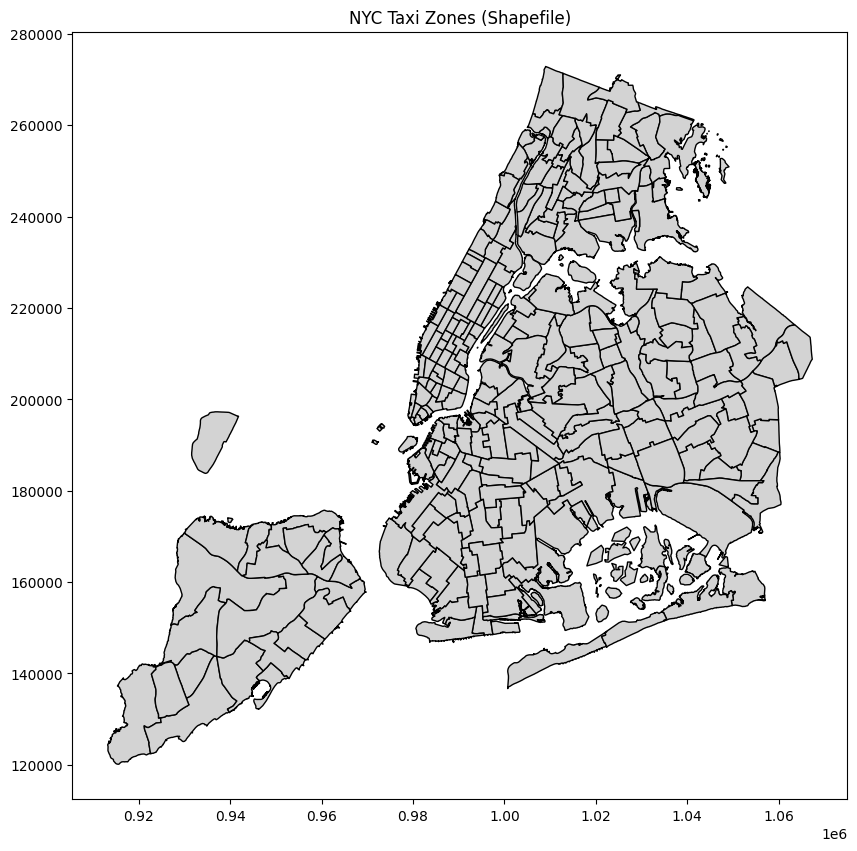

In [721]:
# import geopandas as gpd


# Read the shapefile using geopandas
# zones = # read the .shp file using gpd
# zones.head()

fig, ax = plt.subplots(1,1, figsize=(10,10))
gdf_zones.plot(ax=ax, color='lightgrey', edgecolor='black')
plt.title("NYC Taxi Zones (Shapefile)")
plt.savefig(out_dir / "nyc_zones_shapefile.png")
plt.show()
plt.close()


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [722]:
# print(zones.info())
# zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [723]:
# Merge zones and trip records using locationID and PULocationID
df_with_zones = df.merge(gdf_zones[['LocationID','zone']], 
                         left_on='PULocationID', right_on='LocationID', how='left')
print("\nSample merged df with zones:")
print(df_with_zones[['PULocationID','zone']].head())



Sample merged df with zones:
   PULocationID                       zone
0           138          LaGuardia Airport
1           161             Midtown Center
2           237      Upper East Side South
3           143        Lincoln Square West
4           246  West Chelsea/Hudson Yards


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [724]:
trips_by_loc = df.groupby('PULocationID').size().reset_index(name='trip_count')
print("\nTop locations by trip count:")
print(trips_by_loc.sort_values('trip_count', ascending=False).head(10))



Top locations by trip count:
     PULocationID  trip_count
117           132       19275
216           237       17352
145           161       17139
215           236       15525
146           162       13231
123           138       12703
167           186       12655
209           230       12159
127           142       12074
154           170       10844


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [725]:

zones_with_counts = gdf_zones.merge(trips_by_loc, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_counts['trip_count'] = zones_with_counts['trip_count'].fillna(0)


**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

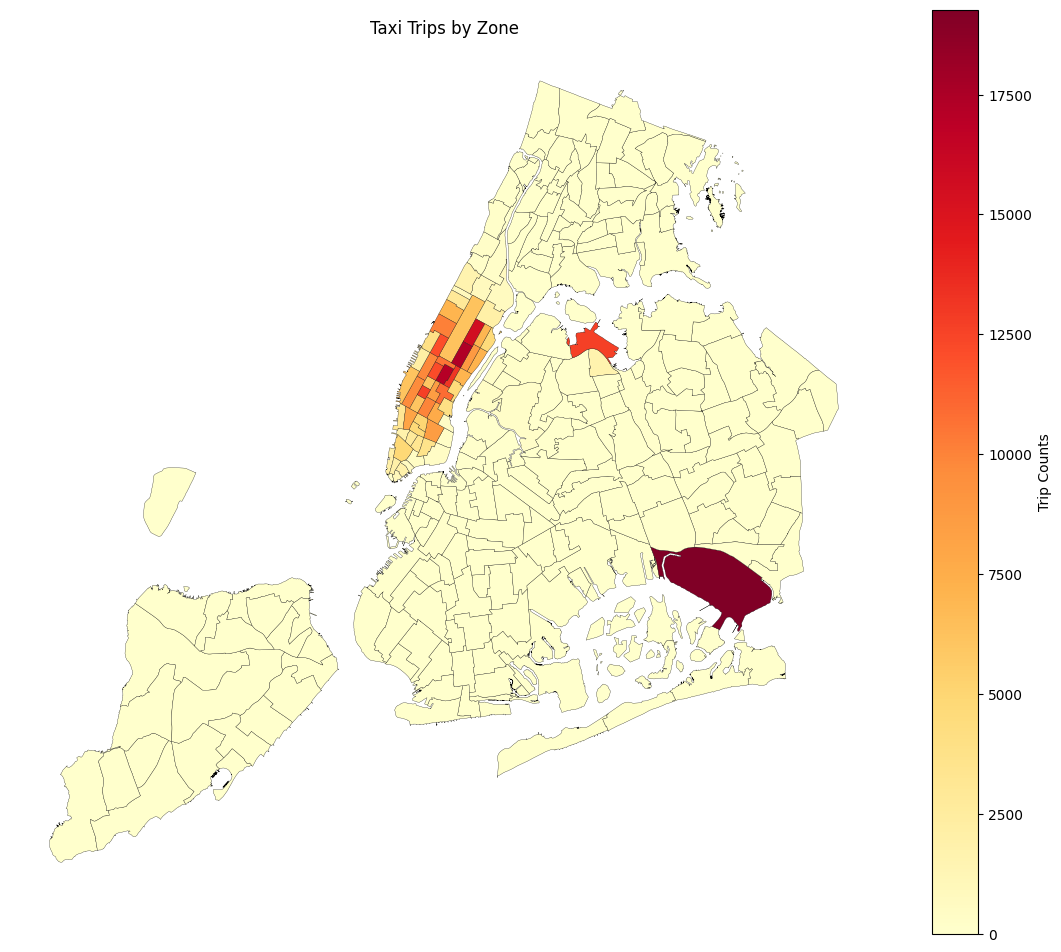

In [726]:
# Define figure and axis
# Plot the map and display it
# can you try displaying the zones DF sorted by the number of trips?

fig, ax = plt.subplots(1,1, figsize=(14,12))
zones_with_counts.plot(column='trip_count', cmap='YlOrRd', legend=True, ax=ax,
                       legend_kwds={'label': "Trip Counts"},
                       edgecolor='black', linewidth=0.2)
ax.set_title("Taxi Trips by Zone")
ax.axis('off')
plt.savefig(out_dir / "zonewise_trip_counts_map.png", bbox_inches='tight')
plt.show()
plt.close()


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [727]:
# Compute average speed per route and per time-of-day bucket
def tod_bucket(hour):
    if 5 <= hour < 9:
        return "Morning_peak"
    if 9 <= hour < 16:
        return "Midday"
    if 16 <= hour < 20:
        return "Evening_peak"
    if 20 <= hour < 23:
        return "Evening"
    return "Night"  # 23-5

df['tod_bucket'] = df['pickup_hour'].apply(tod_bucket)

# define route id
df['route'] = df['PULocationID'].astype(str) + "_" + df['DOLocationID'].astype(str)

# avg speed per route x tod
route_speed = (df.groupby(['route', 'tod_bucket'])
                 .agg(avg_speed_mph=('speed_mph','mean'),
                      trip_count=('speed_mph','count'),
                      median_speed=('speed_mph','median'))
                 .reset_index())
# filter routes with at least some number of trips to be meaningful (e.g., >=5)
route_speed_filtered = route_speed[route_speed['trip_count'] >= 5]

# identify slowest routes per bucket (lowest avg_speed)
slowest_by_bucket = (route_speed_filtered.sort_values(['tod_bucket','avg_speed_mph'])
                     .groupby('tod_bucket').head(10))

print("\nSlowest routes by time-of-day bucket (sample):")
print(slowest_by_bucket[['tod_bucket','route','avg_speed_mph','trip_count']].head(20))



# Find routes which have the slowest speeds at different times of the day
slowest_by_bucket.to_csv(out_dir / "slowest_routes_by_tod.csv", index=False)





Slowest routes by time-of-day bucket (sample):
         tod_bucket    route  avg_speed_mph  trip_count
12672       Evening  193_193       0.000000          16
7583        Evening  146_146       0.791209           7
21299       Evening  265_265       2.673607          32
5           Evening  100_100       2.909747          19
24995       Evening    70_70       3.109429           7
7164        Evening  144_144       4.321686          13
14922       Evening  230_230       4.553667          75
13324       Evening  211_211       4.680352           9
8190        Evening  151_151       4.726826          15
12166       Evening  186_186       4.763753          22
7584   Evening_peak  146_146       0.357143           8
7486   Evening_peak  145_145       1.565078          45
11172  Evening_peak  168_168       2.670134           6
20149  Evening_peak  261_261       3.138224          10
13325  Evening_peak  211_211       3.257073          14
11972  Evening_peak  186_100       3.473017          52


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

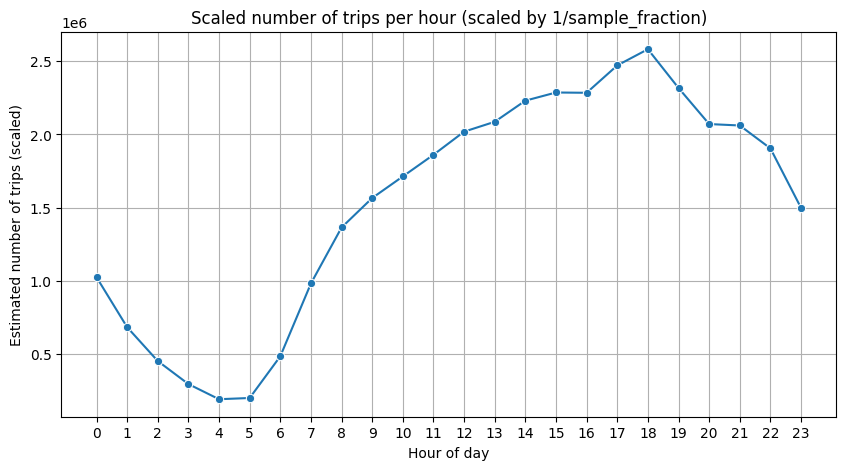


Busiest hour (sample): 18 (scaled est. trips: 2583000)


In [728]:
# Visualise the number of trips per hour and find the busiest hour

trips_per_hour = df.groupby('pickup_hour').size().reset_index(name='trip_count')
trips_per_hour['scaled_trip_count'] = (trips_per_hour['trip_count'] * scale_factor).round().astype(int)

plt.figure(figsize=(10,5))
sns.lineplot(data=trips_per_hour, x='pickup_hour', y='scaled_trip_count', marker='o')
plt.title("Scaled number of trips per hour (scaled by 1/sample_fraction)")
plt.xlabel("Hour of day")
plt.ylabel("Estimated number of trips (scaled)")
plt.xticks(range(0,24))
plt.grid(True)
plt.savefig(out_dir / "trips_per_hour_scaled.png")
plt.show()
plt.close()

busiest_hour_row = trips_per_hour.loc[trips_per_hour['trip_count'].idxmax()]
busiest_hour = int(busiest_hour_row['pickup_hour'])
busiest_hour_scaled = int(busiest_hour_row['scaled_trip_count'])
print(f"\nBusiest hour (sample): {busiest_hour} (scaled est. trips: {busiest_hour_scaled})")



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [729]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.01
scale_factor = 1.0 / sample_fraction

# pickups per PU zone
pickups_per_zone = df.groupby('PULocationID').size().reset_index(name='sample_trip_count')
pickups_per_zone['estimated_trips'] = (pickups_per_zone['sample_trip_count'] * scale_factor).round().astype(int)

# dropoffs per zone
dropoffs_per_zone = df.groupby('DOLocationID').size().reset_index(name='sample_dropoff_count')
dropoffs_per_zone['estimated_dropoffs'] = (dropoffs_per_zone['sample_dropoff_count'] * scale_factor).round().astype(int)

# merge into gdf_zones
gdf_merged = gdf_zones.merge(pickups_per_zone, left_on='LocationID', right_on='PULocationID', how='left')
gdf_merged = gdf_merged.merge(dropoffs_per_zone, left_on='LocationID', right_on='DOLocationID', how='left')
gdf_merged['sample_trip_count'] = gdf_merged['sample_trip_count'].fillna(0).astype(int)
gdf_merged['sample_dropoff_count'] = gdf_merged['sample_dropoff_count'].fillna(0).astype(int)
gdf_merged['estimated_trips'] = gdf_merged['estimated_trips'].fillna(0).astype(int)
gdf_merged['estimated_dropoffs'] = gdf_merged['estimated_dropoffs'].fillna(0).astype(int)





**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

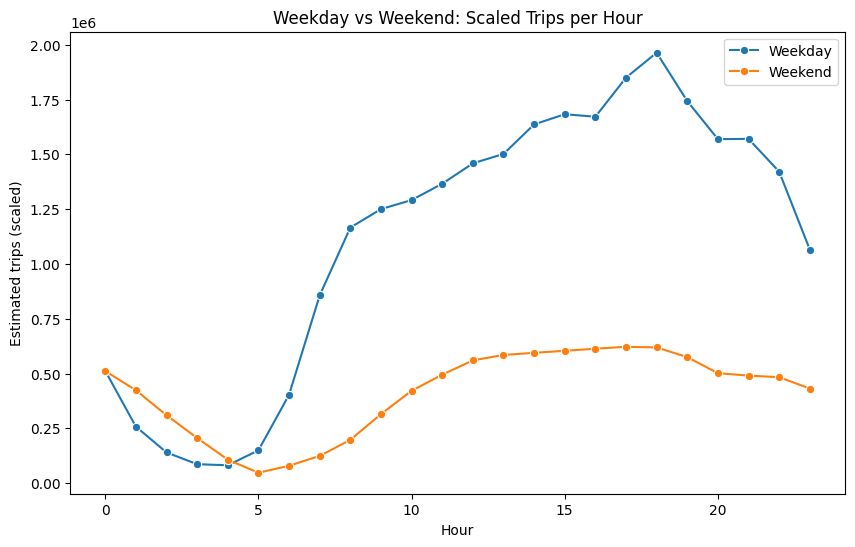

In [730]:
# Compare traffic trends for the week days and weekends
weekday_df = df[df['is_weekend'] == False]
weekend_df = df[df['is_weekend'] == True]

weekday_counts = weekday_df.groupby('pickup_hour').size().reset_index(name='count').set_index('pickup_hour')
weekend_counts = weekend_df.groupby('pickup_hour').size().reset_index(name='count').set_index('pickup_hour')

# scale
weekday_counts['scaled'] = (weekday_counts['count'] * scale_factor).round().astype(int)
weekend_counts['scaled'] = (weekend_counts['count'] * scale_factor).round().astype(int)

plt.figure(figsize=(10,6))
sns.lineplot(data=weekday_counts['scaled'], label='Weekday', marker='o')
sns.lineplot(data=weekend_counts['scaled'], label='Weekend', marker='o')
plt.title("Weekday vs Weekend: Scaled Trips per Hour")
plt.xlabel("Hour")
plt.ylabel("Estimated trips (scaled)")
plt.legend()
plt.savefig(out_dir / "weekday_vs_weekend_trips_per_hour.png")
plt.show()
plt.close()



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [731]:
# Find top 10 pickup and dropoff zones
top10_pickups = pickups_per_zone.sort_values('sample_trip_count', ascending=False).head(10)
top10_dropoffs = dropoffs_per_zone.sort_values('sample_dropoff_count', ascending=False).head(10)

# attach zone names
top10_pickups['zone'] = top10_pickups['PULocationID'].map(locid_to_zone)
top10_dropoffs['zone'] = top10_dropoffs['DOLocationID'].map(locid_to_zone)

print("\nTop 10 pickup zones (sample counts, estimated counts):")
print(top10_pickups[['PULocationID','zone','sample_trip_count','estimated_trips']])

print("\nTop 10 dropoff zones (sample counts, estimated counts):")
print(top10_dropoffs[['DOLocationID','zone','sample_dropoff_count','estimated_dropoffs']])




Top 10 pickup zones (sample counts, estimated counts):
     PULocationID                          zone  sample_trip_count  \
117           132                   JFK Airport              19275   
216           237         Upper East Side South              17352   
145           161                Midtown Center              17139   
215           236         Upper East Side North              15525   
146           162                  Midtown East              13231   
123           138             LaGuardia Airport              12703   
167           186  Penn Station/Madison Sq West              12655   
209           230     Times Sq/Theatre District              12159   
127           142           Lincoln Square East              12074   
154           170                   Murray Hill              10844   

     estimated_trips  
117          1927500  
216          1735200  
145          1713900  
215          1552500  
146          1323100  
123          1270300  
167         

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [732]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

zone_counts = pd.DataFrame({
    'LocationID': gdf_merged['LocationID'],
    'zone': gdf_merged['zone'],
    'estimated_pickups': gdf_merged['estimated_trips'],
    'estimated_dropoffs': gdf_merged['estimated_dropoffs']
})
zone_counts['estimated_dropoffs_adj'] = zone_counts['estimated_dropoffs'].replace({0: np.nan})
zone_counts['pickup_dropoff_ratio'] = zone_counts['estimated_pickups'] / zone_counts['estimated_dropoffs_adj']
# where dropoffs are zero, ratio will be NaN; fill with large number to indicate imbalance if desired
zone_counts['pickup_dropoff_ratio'] = zone_counts['pickup_dropoff_ratio'].replace([np.inf], np.nan)

top10_ratio = zone_counts.sort_values('pickup_dropoff_ratio', ascending=False).head(10)
bottom10_ratio = zone_counts.sort_values('pickup_dropoff_ratio', ascending=True).dropna().head(10)

print("\nTop 10 pickup/dropoff ratio (highest):")
print(top10_ratio[['LocationID','zone','estimated_pickups','estimated_dropoffs','pickup_dropoff_ratio']])

print("\nTop 10 pickup/dropoff ratio (lowest non-zero):")
print(bottom10_ratio[['LocationID','zone','estimated_pickups','estimated_dropoffs','pickup_dropoff_ratio']])



Top 10 pickup/dropoff ratio (highest):
     LocationID                          zone  estimated_pickups  \
69           70                 East Elmhurst             166800   
131         132                   JFK Airport            1927500   
137         138             LaGuardia Airport            1270300   
185         186  Penn Station/Madison Sq West            1265500   
42           43                  Central Park             623500   
248         249                  West Village             816200   
113         114       Greenwich Village South             471800   
161         162                  Midtown East            1323100   
160         161                Midtown Center            1713900   
233         234                      Union Sq             996900   

     estimated_dropoffs  pickup_dropoff_ratio  
69                21100              7.905213  
131              412800              4.669331  
137              436200              2.912196  
185              81

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [733]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_df = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5)]
night_pickups = night_df.groupby('PULocationID').size().reset_index(name='sample_night_pickups')
night_pickups['estimated_night_pickups'] = (night_pickups['sample_night_pickups'] * scale_factor).round().astype(int)
night_pickups = night_pickups.sort_values('sample_night_pickups', ascending=False)

night_dropoffs = df[(df['tpep_dropoff_datetime'].dt.hour >= 23) | (df['tpep_dropoff_datetime'].dt.hour <= 5)]
night_dropoffs = night_dropoffs.groupby('DOLocationID').size().reset_index(name='sample_night_dropoffs')
night_dropoffs['estimated_night_dropoffs'] = (night_dropoffs['sample_night_dropoffs'] * scale_factor).round().astype(int)
night_dropoffs = night_dropoffs.sort_values('sample_night_dropoffs', ascending=False)

# show top night zones
night_pickups['zone'] = night_pickups['PULocationID'].map(locid_to_zone)
night_dropoffs['zone'] = night_dropoffs['DOLocationID'].map(locid_to_zone)
print("\nTop night pickup zones (sample -> estimated):")
print(night_pickups.head(10)[['PULocationID','zone','sample_night_pickups','estimated_night_pickups']])

print("\nTop night dropoff zones (sample -> estimated):")
print(night_dropoffs.head(10)[['DOLocationID','zone','sample_night_dropoffs','estimated_night_dropoffs']])




Top night pickup zones (sample -> estimated):
     PULocationID                          zone  sample_night_pickups  \
55             79                  East Village                  3080   
91            132                   JFK Airport                  2901   
187           249                  West Village                  2540   
30             48                  Clinton East                  2052   
106           148               Lower East Side                  1931   
170           230     Times Sq/Theatre District                  1719   
78            114       Greenwich Village South                  1685   
136           186  Penn Station/Madison Sq West                  1388   
97            138             LaGuardia Airport                  1248   
118           164                 Midtown South                  1217   

     estimated_night_pickups  
55                    308000  
91                    290100  
187                   254000  
30                    205

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [734]:
# Filter for night hours (11 PM to 5 AM)

df['is_night'] = df['pickup_hour'].apply(lambda h: True if (h >= 23 or h <= 5) else False)
revenue_by_night = df.groupby('is_night')['total_amount'].sum().reset_index()
revenue_by_night['scaled_revenue'] = revenue_by_night['total_amount'] * scale_factor
print("\nRevenue share (sample totals and scaled estimates):")
print(revenue_by_night)

# also compute proportion
total_rev = revenue_by_night['scaled_revenue'].sum()
revenue_by_night['proportion'] = revenue_by_night['scaled_revenue'] / total_rev
print("\nRevenue proportions (night vs day):")
print(revenue_by_night[['is_night','proportion']])



Revenue share (sample totals and scaled estimates):
   is_night  total_amount  scaled_revenue
0     False    9408375.16     940837516.0
1      True    1279676.54     127967654.0

Revenue proportions (night vs day):
   is_night  proportion
0     False     0.88027
1      True     0.11973


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.


Fare-per-mile-per-passenger by passenger_count:
   passenger_count  count_trips  mean_farepmpp  median_farepmpp  std_farepmpp
0              1.0       272615      11.444532         7.174603    409.745220
1              2.0        54594       6.379736         3.511518     81.284861
2              3.0        13545       4.254586         2.368421     63.428256
3              4.0         7450       4.746516         1.785714     72.450959
4              5.0         4724       1.570459         1.418588      1.625510
5              6.0         3170       1.289554         1.194865      1.003280


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/3873562692.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


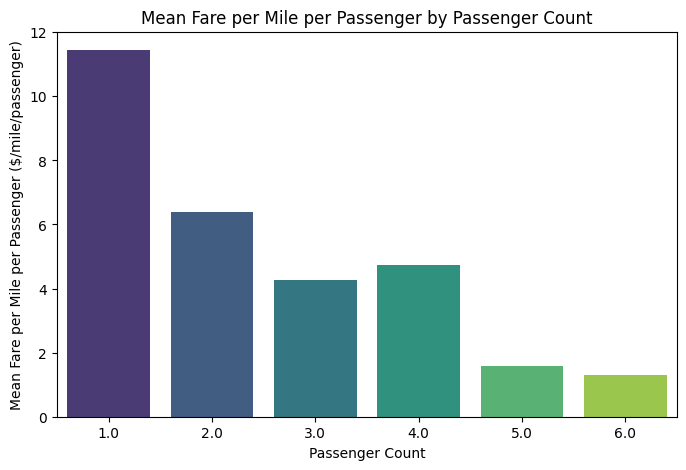

In [735]:
# Analyse the fare per mile per passenger for different passenger counts

# Ensure no division by zero
df = df[df['trip_distance'] > 0]
df = df[df['passenger_count'] > 0]

# Create fare per mile per passenger column
df['fare_per_mile_per_passenger'] = df['fare_amount'] / (df['trip_distance'] * df['passenger_count'])

# Group by passenger_count and calculate statistics
farepm_passenger = (
    df.groupby('passenger_count', as_index=False)
      .agg(
          count_trips=('fare_per_mile_per_passenger','count'),
          mean_farepmpp=('fare_per_mile_per_passenger','mean'),
          median_farepmpp=('fare_per_mile_per_passenger','median'),
          std_farepmpp=('fare_per_mile_per_passenger','std')
      )
      .sort_values('passenger_count')
)

# Save to CSV
farepm_passenger.to_csv(out_dir / "fare_per_mile_per_passenger_by_passenger_count.csv", index=False)

# Print results
print("\nFare-per-mile-per-passenger by passenger_count:")
print(farepm_passenger.head(20))

# Plot mean fare per mile per passenger
plt.figure(figsize=(8,5))
sns.barplot(
    data=farepm_passenger[farepm_passenger['count_trips']>0],
    x='passenger_count', y='mean_farepmpp', palette='viridis'
)
plt.title("Mean Fare per Mile per Passenger by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Mean Fare per Mile per Passenger ($/mile/passenger)")
plt.savefig(out_dir / "mean_farepmpp_by_passenger_count.png")
plt.show()
plt.close()


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week


Fare per mile by day of week:
   pickup_dayofweek  mean_farepm  med_farepm  trips
0                 0    10.807557    6.923077  44419
1                 1    14.542929    7.391304  51794
2                 2    10.983402    7.440000  54809
3                 3    12.295271    7.457143  56009
4                 4    10.672091    7.250000  52691
5                 5    10.973236    7.051161  51670
6                 6    12.062180    6.500000  44706

Fare per mile by time-of-day bucket:
     tod_bucket  mean_farepm  med_farepm   trips
0       Evening    10.039874    6.540541   59046
1  Evening_peak    12.030363    7.529412   94038
2        Midday    12.809389    7.738095  133444
3  Morning_peak    10.519605    6.632653   29336
4         Night    11.195247    5.972222   40234


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2197723387.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farepm_by_day, x='pickup_dayofweek', y='mean_farepm', palette='coolwarm')
/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2197723387.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farepm_by_tod, x='tod_bucket', y='mean_farepm', order=order, palette='magma')


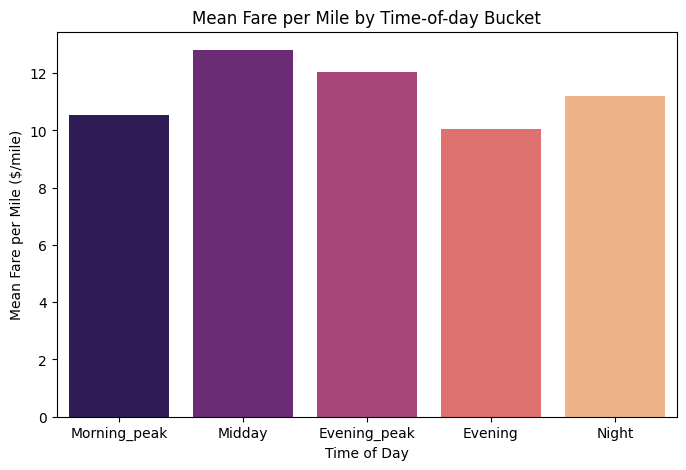

In [736]:
# Compare the average fare per mile for different days and for different times of the day

# Ensure no division by zero
df = df[df['trip_distance'] > 0]

# Create fare per mile column
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']

# --- By day of week ---
farepm_by_day = (
    df.groupby('pickup_dayofweek', as_index=False)
      .agg(
          mean_farepm=('fare_per_mile','mean'),
          med_farepm=('fare_per_mile','median'),
          trips=('fare_per_mile','count')
      )
      .sort_values('pickup_dayofweek')
)

farepm_by_day.to_csv(out_dir / "fare_per_mile_by_day.csv", index=False)
print("\nFare per mile by day of week:")
print(farepm_by_day)

plt.figure(figsize=(8,5))
sns.barplot(data=farepm_by_day, x='pickup_dayofweek', y='mean_farepm', palette='coolwarm')
plt.title("Mean Fare per Mile by Day of Week (0=Mon)")
plt.xlabel("Day of Week")
plt.ylabel("Mean Fare per Mile ($/mile)")
plt.savefig(out_dir / "mean_farepm_by_day.png")
plt.close()

# --- By time-of-day bucket ---
farepm_by_tod = (
    df.groupby('tod_bucket', as_index=False)
      .agg(
          mean_farepm=('fare_per_mile','mean'),
          med_farepm=('fare_per_mile','median'),
          trips=('fare_per_mile','count')
      )
)

farepm_by_tod.to_csv(out_dir / "fare_per_mile_by_tod_bucket.csv", index=False)
print("\nFare per mile by time-of-day bucket:")
print(farepm_by_tod)

plt.figure(figsize=(8,5))
order = ["Morning_peak","Midday","Evening_peak","Evening","Night"]
sns.barplot(data=farepm_by_tod, x='tod_bucket', y='mean_farepm', order=order, palette='magma')
plt.title("Mean Fare per Mile by Time-of-day Bucket")
plt.xlabel("Time of Day")
plt.ylabel("Mean Fare per Mile ($/mile)")
plt.savefig(out_dir / "mean_farepm_by_tod.png")
plt.show()
plt.close()


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day


Fare per mile by Vendor:
   VendorID  mean_farepm  med_farepm   trips
0         1    10.341841    7.142857   88892
1         2    12.249678    7.154930  267206


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/553383609.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farepm_by_vendor, x='VendorID', y='mean_farepm', palette='Set2')


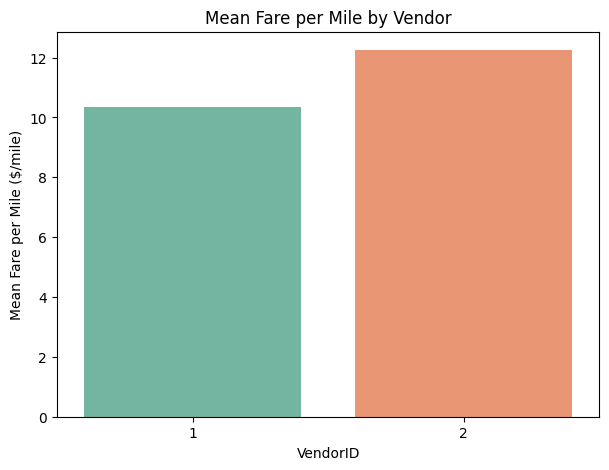

In [737]:
# Compare fare per mile for different vendors
if 'VendorID' in df.columns:
    farepm_by_vendor = (df.groupby('VendorID', as_index=False)
                         .agg(mean_farepm=('fare_per_mile','mean'),
                              med_farepm=('fare_per_mile','median'),
                              trips=('fare_per_mile','count')))
    farepm_by_vendor.to_csv(out_dir / "fare_per_mile_by_vendor.csv", index=False)
    print("\nFare per mile by Vendor:")
    print(farepm_by_vendor)

    plt.figure(figsize=(7,5))
    sns.barplot(data=farepm_by_vendor, x='VendorID', y='mean_farepm', palette='Set2')
    plt.title("Mean Fare per Mile by Vendor")
    plt.xlabel("VendorID")
    plt.ylabel("Mean Fare per Mile ($/mile)")
    plt.savefig(out_dir / "mean_farepm_by_vendor.png")
    plt.show()
    plt.close()




**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.



Fare per mile by distance bucket:
  dist_bucket  mean_farepm  median_farepm   trips
0         0-2    16.622707       8.554217  197727
1         2-5     6.503628       6.208333   97074
2          >5     4.476620       4.297521   61297


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2947030324.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farepm_by_distbucket.sort_values('dist_bucket'), x='dist_bucket', y='mean_farepm', palette='viridis')


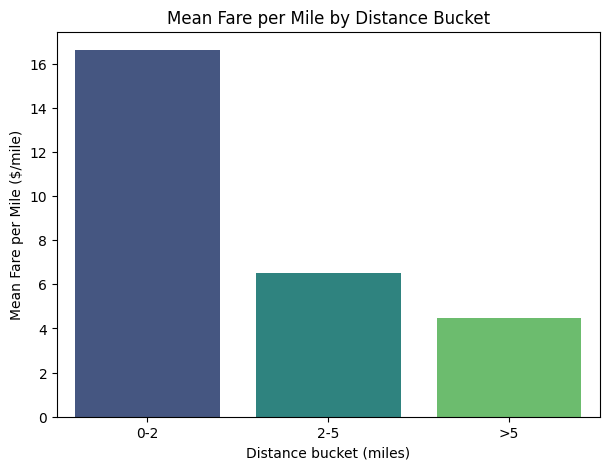

In [738]:
# Defining distance tiers
def dist_bucket(d):
    if d <= 2:
        return "0-2"
    if d <= 5:
        return "2-5"
    return ">5"

df['dist_bucket'] = df['trip_distance'].apply(dist_bucket)

farepm_by_distbucket = (df.groupby('dist_bucket', as_index=False)
                          .agg(mean_farepm=('fare_per_mile','mean'),
                               median_farepm=('fare_per_mile','median'),
                               trips=('fare_per_mile','count')))
farepm_by_distbucket.to_csv(out_dir / "fare_per_mile_by_distance_bucket.csv", index=False)
print("\nFare per mile by distance bucket:")
print(farepm_by_distbucket)

plt.figure(figsize=(7,5))
sns.barplot(data=farepm_by_distbucket.sort_values('dist_bucket'), x='dist_bucket', y='mean_farepm', palette='viridis')
plt.title("Mean Fare per Mile by Distance Bucket")
plt.xlabel("Distance bucket (miles)")
plt.ylabel("Mean Fare per Mile ($/mile)")
plt.savefig(out_dir / "mean_farepm_by_distance_bucket.png")
plt.show()
plt.close()



##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [739]:
# Analyze tip percentages based on distances, passenger counts and pickup times

# Ensure no division by zero
df = df[df['fare_amount'] > 0]

# Create tip percentage column
df['tip_pct'] = df['tip_amount'] / df['fare_amount'] * 100

# --- Tip vs distance buckets ---
tip_by_dist = (
    df.groupby('dist_bucket', as_index=False)
      .agg(
          mean_tip_pct=('tip_pct','mean'),
          median_tip_pct=('tip_pct','median'),
          trips=('tip_pct','count')
      )
)
tip_by_dist.to_csv(out_dir / "tip_pct_by_distance_bucket.csv", index=False)
print("\nTip pct by distance bucket:")
print(tip_by_dist)

plt.figure(figsize=(8,5))
sns.boxplot(
    x='dist_bucket', y='tip_pct', 
    data=df[df['tip_pct'].notna()], 
    order=["0-2","2-5",">5"]
)
plt.title("Tip Percentage by Distance Bucket")
plt.xlabel("Distance bucket")
plt.ylabel("Tip %")
plt.savefig(out_dir / "tip_pct_box_by_distance_bucket.png")
plt.close()

# --- Tip vs passenger_count ---
tip_by_pax = (
    df.groupby('passenger_count', as_index=False)
      .agg(
          mean_tip_pct=('tip_pct','mean'),
          median_tip_pct=('tip_pct','median'),
          trips=('tip_pct','count')
      )
)
tip_by_pax.to_csv(out_dir / "tip_pct_by_passenger_count.csv", index=False)
print("\nTip pct by passenger_count:")
print(tip_by_pax.head(15))

plt.figure(figsize=(10,5))
sns.lineplot(
    data=tip_by_pax, x='passenger_count', y='mean_tip_pct', marker='o'
)
plt.title("Mean Tip % by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Mean Tip %")
plt.savefig(out_dir / "mean_tippct_by_passenger_count.png")
plt.close()

# --- Tip vs time-of-day bucket ---
tip_by_tod = (
    df.groupby('tod_bucket', as_index=False)
      .agg(
          mean_tip_pct=('tip_pct','mean'),
          median_tip_pct=('tip_pct','median'),
          trips=('tip_pct','count')
      )
)
tip_by_tod.to_csv(out_dir / "tip_pct_by_tod_bucket.csv", index=False)
print("\nTip pct by time-of-day bucket:")
print(tip_by_tod)

plt.figure(figsize=(8,5))
order = ["Morning_peak","Midday","Evening_peak","Evening","Night"]
sns.barplot(
    data=tip_by_tod, x='tod_bucket', y='mean_tip_pct', order=order
)
plt.title("Mean Tip % by Time-of-day Bucket")
plt.xlabel("Time of Day")
plt.ylabel("Mean Tip %")
plt.savefig(out_dir / "mean_tippct_by_tod_bucket.png")
plt.close()



Tip pct by distance bucket:
  dist_bucket  mean_tip_pct  median_tip_pct   trips
0         0-2     22.488580       26.611570  197685
1         2-5     18.773003       23.652968   97071
2          >5     16.519256       21.428571   61274

Tip pct by passenger_count:
   passenger_count  mean_tip_pct  median_tip_pct   trips
0              1.0     20.743657       24.248927  272554
1              2.0     19.722011       23.539823   54589
2              3.0     18.957193       23.238866   13543
3              4.0     17.331080       22.438365    7450
4              5.0     20.881234       24.291845    4724
5              6.0     20.599886       24.300739    3170

Tip pct by time-of-day bucket:
     tod_bucket  mean_tip_pct  median_tip_pct   trips
0       Evening     21.446689       24.793388   59041
1  Evening_peak     21.826973       25.118110   94018
2        Midday     19.210121       23.433476  133415
3  Morning_peak     19.518968       23.149606   29328
4         Night     20.543831    

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours


Tip group comparison (<10%, 10-25%, >25%):
  tip_group   trips  mean_fare  median_fare  mean_dist  mean_passengers
0    10-25%  102949  26.049705         19.1   4.961503         1.387211
1      <10%   92474  23.092841         14.2   3.915626         1.433981
2      >25%  160607  14.375967         11.4   2.293457         1.365962


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/162075047.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tipgroup_stats, x='tip_group', y='trips', palette='Set1')


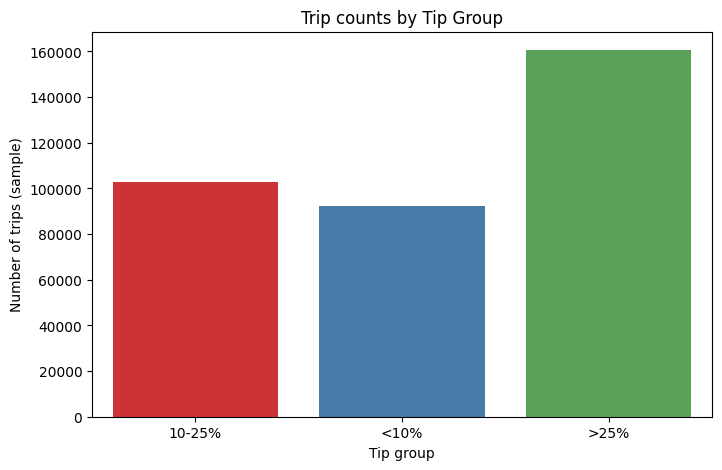

In [740]:
# Analyze tip percentages based on distances, passenger counts and pickup times
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

df['tip_group'] = np.where(df['tip_pct'] < 10, '<10%', np.where(df['tip_pct'] > 25, '>25%', '10-25%'))

tipgroup_stats = (df.groupby('tip_group', as_index=False)
                   .agg(trips=('tip_pct','count'),
                        mean_fare=('fare_amount','mean'),
                        median_fare=('fare_amount','median'),
                        mean_dist=('trip_distance','mean'),
                        mean_passengers=('passenger_count','mean')))
tipgroup_stats.to_csv(out_dir / "tip_group_comparison.csv", index=False)
print("\nTip group comparison (<10%, 10-25%, >25%):")
print(tipgroup_stats)

plt.figure(figsize=(8,5))
sns.barplot(data=tipgroup_stats, x='tip_group', y='trips', palette='Set1')
plt.title("Trip counts by Tip Group")
plt.xlabel("Tip group")
plt.ylabel("Number of trips (sample)")
plt.savefig(out_dir / "trip_counts_by_tip_group.png")
plt.show()
plt.close()



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [741]:
# See how passenger count varies across hours and days

pax_by_hour = (df.groupby('pickup_hour', as_index=False)
                 .agg(mean_pax=('passenger_count','mean'),
                      median_pax=('passenger_count','median'),
                      trips=('passenger_count','count')))
pax_by_hour.to_csv(out_dir / "passenger_count_by_hour.csv", index=False)

plt.figure(figsize=(10,5))
sns.lineplot(data=pax_by_hour, x='pickup_hour', y='mean_pax', marker='o')
plt.title("Mean Passenger Count by Hour")
plt.xlabel("Hour")
plt.ylabel("Mean Passenger Count")
plt.xticks(range(0,24))
plt.savefig(out_dir / "mean_passenger_count_by_hour.png")
plt.close()

pax_by_day = (df.groupby('pickup_dayofweek', as_index=False)
                .agg(mean_pax=('passenger_count','mean'),
                     trips=('passenger_count','count')))
pax_by_day.to_csv(out_dir / "passenger_count_by_day.csv", index=False)

plt.figure(figsize=(8,5))
sns.barplot(data=pax_by_day, x='pickup_dayofweek', y='mean_pax', palette='cool')
plt.title("Mean Passenger Count by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Mean Passenger Count")
plt.savefig(out_dir / "mean_passenger_count_by_day.png")
plt.close()



/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/4202580045.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pax_by_day, x='pickup_dayofweek', y='mean_pax', palette='cool')


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [742]:
# How does passenger count vary across zones
pax_by_zone = (df.groupby('PU_zone', as_index=False)
                 .agg(mean_pax=('passenger_count','mean'),
                      median_pax=('passenger_count','median'),
                      trips=('passenger_count','count'))
                 .sort_values('trips', ascending=False))
pax_by_zone.to_csv(out_dir / "passenger_count_by_zone.csv", index=False)
print("\nTop zones by number of trips and mean passenger count:")
print(pax_by_zone.head(15))


Top zones by number of trips and mean passenger count:
                          PU_zone  mean_pax  median_pax  trips
111                   JFK Airport  1.504085         1.0  18729
213         Upper East Side South  1.337862         1.0  17004
142                Midtown Center  1.402160         1.0  16762
212         Upper East Side North  1.353950         1.0  15166
143                  Midtown East  1.341454         1.0  12930
120             LaGuardia Airport  1.366717         1.0  12481
165  Penn Station/Madison Sq West  1.357131         1.0  12326
205     Times Sq/Theatre District  1.497392         1.0  11888
124           Lincoln Square East  1.386976         1.0  11794
151                   Murray Hill  1.360314         1.0  10588
144                 Midtown North  1.404613         1.0  10363
215         Upper West Side South  1.377564         1.0   9895
209                      Union Sq  1.368421         1.0   9747
42                   Clinton East  1.404005         1.0   9589

In [743]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zone_mean_pax = pax_by_zone.set_index('PU_zone')['mean_pax'].to_dict()
df['avg_passenger_count_zone'] = df['PU_zone'].map(zone_mean_pax).fillna(df['passenger_count'].mean())

# Save a CSV of df with avg_passenger_count_zone for inspection
df[['PULocationID','PU_zone','passenger_count','avg_passenger_count_zone']].head(20).to_csv(out_dir / "sample_with_avg_passenger_zone.csv", index=False)


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently


Surcharge application statistics:
               surcharge  applied_count  applied_pct  mean_when_applied
0  improvement_surcharge         356025    99.998596           0.999715
1   congestion_surcharge         330887    92.937955           2.500000
4                  extra         219558    61.668399           2.620950
3            airport_fee          31267     8.782125           1.625060
2           tolls_amount          28705     8.062523           7.311188


/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2636425835.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=surcharge_df, x='surcharge', y='applied_count', palette='rocket')


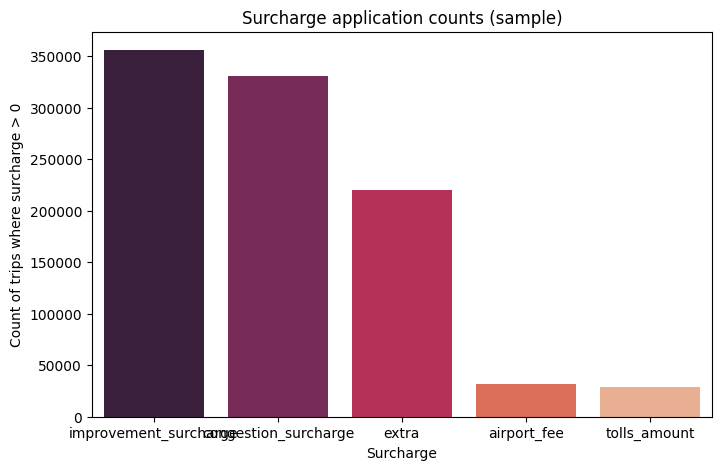

/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2636425835.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = (df.groupby('tod_bucket').apply(lambda g: (g[col]>0).sum()).reset_index(name='applied_count'))
/var/folders/dy/5yy4yh9s6dbfp7vs88jmyckw0000gn/T/ipykernel_71352/2636425835.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = (df.groupby('tod_bucket').apply(lambda g: (g[col]>0


All analysis outputs saved under: /Users/bhavukmathur/Desktop/Bhavuk_Mathur/Education/upgrad/assign1/trip_records


In [744]:
# How often is each surcharge applied?
surcharge_cols = ['improvement_surcharge', 'congestion_surcharge', 'tolls_amount', 'airport_fee', 'extra']
surcharge_stats = []
for col in surcharge_cols:
    if col in df.columns:
        applied = (df[col] > 0).sum()
        total = len(df)
        pct = applied / total * 100.0
        mean_val = df.loc[df[col] > 0, col].mean() if applied>0 else 0
        surcharge_stats.append({'surcharge': col, 'applied_count': int(applied), 'applied_pct': pct, 'mean_when_applied': mean_val})
surcharge_df = pd.DataFrame(surcharge_stats).sort_values('applied_count', ascending=False)
surcharge_df.to_csv(out_dir / "surcharge_application_stats.csv", index=False)
print("\nSurcharge application statistics:")
print(surcharge_df)

# Visualize surcharge application frequency
plt.figure(figsize=(8,5))
sns.barplot(data=surcharge_df, x='surcharge', y='applied_count', palette='rocket')
plt.title("Surcharge application counts (sample)")
plt.xlabel("Surcharge")
plt.ylabel("Count of trips where surcharge > 0")
plt.savefig(out_dir / "surcharge_application_counts.png")
plt.show()
plt.close()

# Also show surcharge frequency by time-of-day bucket (how often applied per bucket)
surcharge_by_tod = []
for col in surcharge_cols:
    if col in df.columns:
        stats = (df.groupby('tod_bucket').apply(lambda g: (g[col]>0).sum()).reset_index(name='applied_count'))
        stats['surcharge'] = col
        stats['bucket_total'] = df.groupby('tod_bucket').size().values
        stats['applied_pct'] = stats['applied_count'] / stats['bucket_total'] * 100.0
        surcharge_by_tod.append(stats)
if surcharge_by_tod:
    surcharge_by_tod_df = pd.concat(surcharge_by_tod, ignore_index=True)
    surcharge_by_tod_df.to_csv(out_dir / "surcharge_by_tod_bucket.csv", index=False)

farepm_passenger.to_csv(out_dir / "farepm_passenger_summary.csv", index=False)
farepm_by_day.to_csv(out_dir / "farepm_by_day.csv", index=False)
farepm_by_tod.to_csv(out_dir / "farepm_by_tod.csv", index=False)
if 'farepm_by_vendor' in locals():
    farepm_by_vendor.to_csv(out_dir / "farepm_by_vendor.csv", index=False)
farepm_by_distbucket.to_csv(out_dir / "farepm_by_distbucket.csv", index=False)

# Save final sample (with added derived columns)
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str)

final_csv = out_dir / "sample_2023_clean_analysis_ready.csv"
final_parquet = out_dir / "sample_2023_clean_analysis_ready.parquet"
df.to_csv(final_csv, index=False)
df.to_parquet(final_parquet, index=False, engine="pyarrow")

print("\nAll analysis outputs saved under:", out_dir)


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [745]:
# Match taxi availability with expected demand using a flexible, data-driven approach. Before the morning rush, predictive systems place taxis in Manhattan and other busy areas. Real-time GPS helps drivers take the fastest routes. Midday, some taxis go to airports while others get maintenance. Evening and late-night shifts focus on business districts, entertainment areas, and transit hubs. On weekends, taxis are deployed later in the morning and stay longer in popular leisure spots.

# Key Actions

# Predictive Positioning: Move taxis to busy areas before peak times using past data.
# Real-Time Routing: Use GPS to find the quickest paths and avoid traffic.
# Smart Scheduling: Do maintenance during quiet times to keep more taxis available during busy hours.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [746]:
# Key Recommendations

# Manhattan Core: Keep 30-40% of taxis here for weekday commuters; shift to entertainment areas on weekend evenings. Increase by 15-20% during holidays.
# Airports (JFK & LaGuardia): Assign 15–20% of taxis, boosting early mornings for departures and late evenings for arrivals.
# Outer Boroughs: Place 15-20% near major subway and bus hubs for last-mile trips, especially late nights.
# All Zones: Increase taxis during bad weather. For events, position taxis near venues before crowds leave.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [747]:
# Pricing Recommendations

# Time-Based Pricing: Apply 1.2–1.5x surge during morning/evening peaks. Charge 10–15% more for late-night trips and add weekend surcharges in entertainment areas.
# Distance & Zones: Raise per-mile rates for trips over 10 miles. Keep short-trip fares competitive. Use fixed rates for popular routes like airports.
# Discounts & Surcharges: Give 5–10% loyalty discounts. Add 1.2–1.4x surcharges for bad weather or events. Keep holiday fares competitive.
# This approach boosts revenue during peaks while staying competitive during slower times.